## **Naive Bayes from Scratch**

In [2]:
import numpy as np
import matplotlib.pyplot as plt

This function creates synthetic data with various noise patterns and with non linearly separable classes. Also, there's significant overlap between classes

In [5]:
def generate_data(n_samples=1000, n_features=2):
    """
    Generate complex synthetic data for binary classification with overlapping classes
    and multiple clusters per class.
    """
    X = np.zeros((n_samples, n_features))
    y = np.zeros(n_samples)
    
    samples_per_class = n_samples // 2
    
    class_0_indices = range(samples_per_class)
    
    cluster1_mask = range(samples_per_class // 3)
    cluster2_mask = range(samples_per_class // 3, 2 * (samples_per_class // 3))
    cluster3_mask = range(2 * (samples_per_class // 3), samples_per_class)
    
    X[cluster1_mask] = np.random.normal(-1, 0.8, (len(cluster1_mask), n_features))
    
    X[cluster2_mask] = np.random.normal(1, 0.7, (len(cluster2_mask), n_features))
    
    X[cluster3_mask] = np.random.normal(0, 0.6, (len(cluster3_mask), n_features))
    
    class_1_indices = range(samples_per_class, n_samples)
    
    cluster4_mask = range(samples_per_class, samples_per_class + samples_per_class // 3)
    cluster5_mask = range(samples_per_class + samples_per_class // 3, 
                         samples_per_class + 2 * (samples_per_class // 3))
    cluster6_mask = range(samples_per_class + 2 * (samples_per_class // 3), n_samples)
    
    X[cluster4_mask] = np.random.normal([0, 2], [0.7, 0.7], (len(cluster4_mask), n_features))
    
    X[cluster5_mask] = np.random.normal([2, 0], [0.8, 0.8], (len(cluster5_mask), n_features))
    
    X[cluster6_mask] = np.random.normal([1.5, 1.5], [0.6, 0.6], (len(cluster6_mask), n_features))
    
    X += np.random.uniform(-0.2, 0.2, X.shape)
    
    y[samples_per_class:] = 1
    
    shuffle_idx = np.random.permutation(n_samples)
    X = X[shuffle_idx]
    y = y[shuffle_idx]
    
    return X, y

def train_test_split(X, y, test_size=0.2):
    """
    Split the data into training and testing sets
    """
    n_samples = len(y)
    n_test = int(n_samples * test_size)
    
    indices = np.random.permutation(n_samples)
    test_indices = indices[:n_test]
    train_indices = indices[n_test:]
    
    X_train = X[train_indices]
    X_test = X[test_indices]
    y_train = y[train_indices]
    y_test = y[test_indices]
    
    return X_train, X_test, y_train, y_test

## Class Structure and Methods

### Class Initialization

`def __init__(self):`

Initializes four key attributes:
- classes: Stores unique class labels
- mean: Stores mean values for each feature per class
- var: Stores variance values for each feature per class
- priors: Stores prior probabilities of each class


### Training Method

`def fit(self, X, y):`

Learns the parameters from the training data:

1- Calculates means for each feature in each class  
2- Calculates variances for each feature in each class  
3- Computes prior probabilities for each class  


Adds small constant (1e-10) to variance to prevent division by zero


### Probability Density Function

`def gaussian_density(self, class_idx, x):`

Implements the Gaussian probability density function:

- Uses learned means and variances to compute likelihood
- Formula: $\frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x-\mu)^2}{2\sigma^2}\right)$
- Returns probability density for a given feature value



### Prediction Method

`def predict(self, X):`

Makes predictions for new data points:

1- Calculates posterior probabilities using:        
- Prior probabilities (class frequencies)        
- Likelihood (using Gaussian density)\
  
2- Uses log probabilities to prevent numerical underflow\
3- Returns the class with highest posterior probability

In [8]:
class NaiveBayes:
    def __init__(self):
        self.classes = None
        self.mean = None
        self.var = None
        self.priors = None
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes = np.unique(y)
        n_classes = len(self.classes)
        
        self.mean = np.zeros((n_classes, n_features))
        self.var = np.zeros((n_classes, n_features))
        self.priors = np.zeros(n_classes)
        
        for idx, c in enumerate(self.classes):
            X_c = X[y == c]
            self.mean[idx, :] = np.mean(X_c, axis=0)
            self.var[idx, :] = np.var(X_c, axis=0) + 1e-10
            self.priors[idx] = len(X_c) / float(n_samples)
    
    def gaussian_density(self, class_idx, x):
        mean = self.mean[class_idx]
        var = self.var[class_idx]
        numerator = np.exp(-((x - mean) ** 2) / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator
    
    def predict(self, X):
        y_pred = []
        
        for x in X:
            posteriors = []
            
            for idx, c in enumerate(self.classes):
                prior = np.log(self.priors[idx])
                class_conditional = np.sum(np.log(self.gaussian_density(idx, x)))
                posterior = prior + class_conditional
                posteriors.append(posterior)
            
            y_pred.append(self.classes[np.argmax(posteriors)])
        
        return np.array(y_pred)

These functions calculate the model metrics and provide a comprehensive visualization of the data.

In [11]:
def calculate_metrics(y_true, y_pred):
    """
    Calculate performance metrics
    """
    accuracy = np.mean(y_true == y_pred)
    
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }


def plot_raw_data(X_train, X_test, subplot_idx):
    """
    Plot the raw data without class labels
    """
    plt.subplot(1, 3, subplot_idx)
    
    plt.scatter(X_train[:, 0], X_train[:, 1],
               c='gray', label='Train',
               alpha=0.5, marker='o')
    
    plt.scatter(X_test[:, 0], X_test[:, 1],
               c='dimgray', label='Test',
               alpha=0.5, marker='^')
    
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Raw Data Distribution')
    plt.legend()

def plot_labeled_data(X_train, X_test, y_train, y_test, title, subplot_idx):
    """
    Plot the data with class labels
    """
    plt.subplot(1, 3, subplot_idx)
    
    for label in [0, 1]:
        mask_train = y_train == label
        plt.scatter(X_train[mask_train, 0], 
                   X_train[mask_train, 1],
                   c='blue' if label == 0 else 'red',
                   label=f'Class {label} (Train)',
                   alpha=0.5,
                   marker='o')
        
        mask_test = y_test == label
        plt.scatter(X_test[mask_test, 0],
                   X_test[mask_test, 1],
                   c='blue' if label == 0 else 'red',
                   label=f'Class {label} (Test)',
                   alpha=0.5,
                   marker='^')
    
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.legend()

def visualize_results(X_train, X_test, y_train, y_test, y_train_pred, y_test_pred):
    """
    Create visualization of raw data, true classes, and predicted classes
    """
    plt.figure(figsize=(20, 6))
    
    plot_raw_data(X_train, X_test, 1)
    
    plot_labeled_data(X_train, X_test, y_train, y_test, 
                     'True Class Distribution', 2)
    
    plot_labeled_data(X_train, X_test, y_train_pred, y_test_pred, 
                     'Predicted Class Distribution', 3)
    
    plt.tight_layout()
    plt.show()


Test Set Metrics:
accuracy: 0.780
precision: 0.732
recall: 0.891
f1_score: 0.804


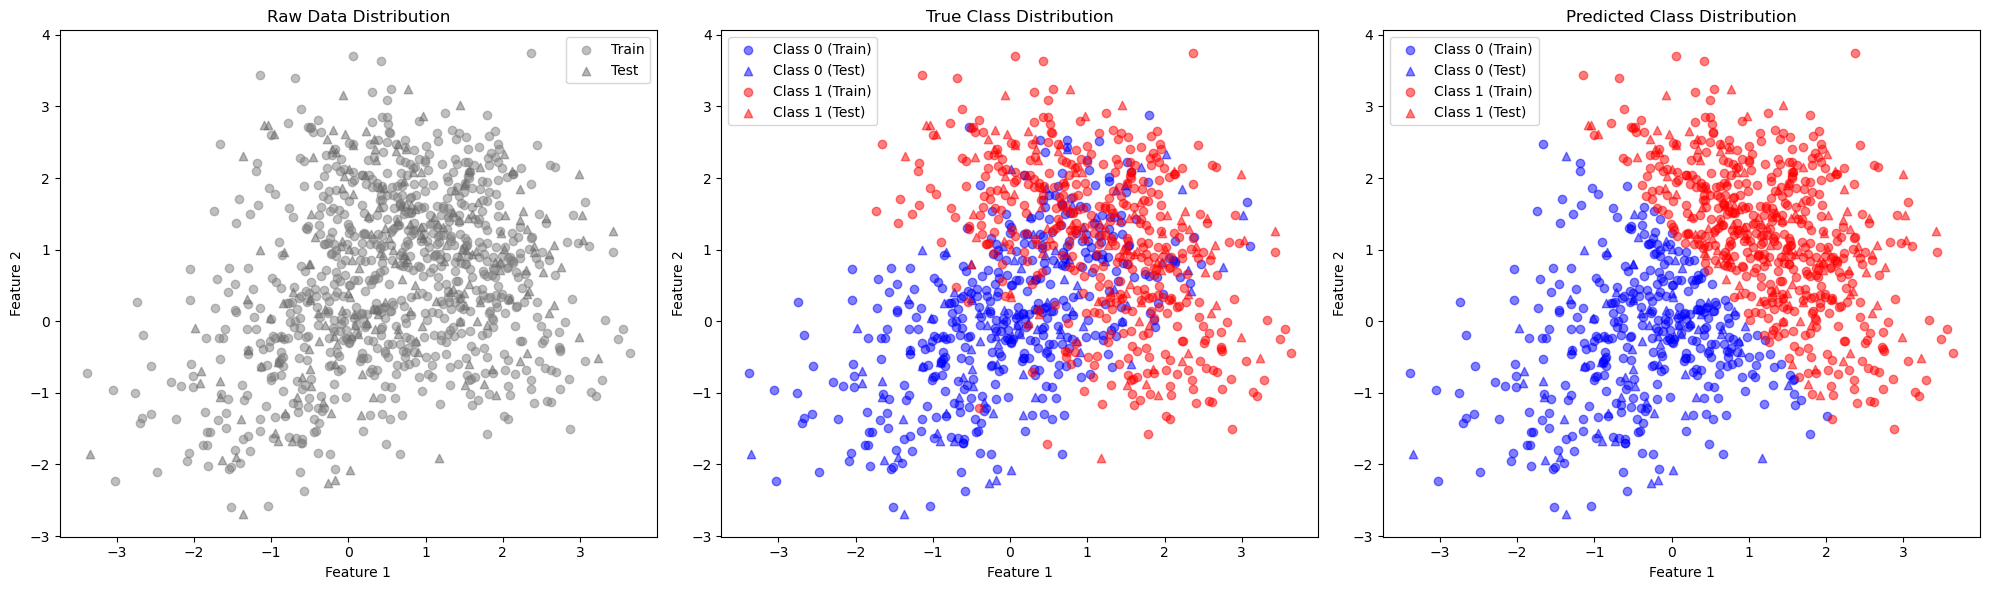

In [13]:
if __name__ == "__main__":
    
    X, y = generate_data(n_samples=1000, n_features=2)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    nb = NaiveBayes()
    nb.fit(X_train, y_train)
    
    y_train_pred = nb.predict(X_train)
    y_test_pred = nb.predict(X_test)
    
    metrics = calculate_metrics(y_test, y_test_pred)
    print("\nTest Set Metrics:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.3f}")
    
    visualize_results(X_train, X_test, y_train, y_test, y_train_pred, y_test_pred)